In [1]:
%matplotlib inline


# Histogram of Oriented Gradients


The Histogram of Oriented Gradient (HOG) feature descriptor is popular
for object detection [1]_.

In the following example, we compute the `HOG descriptor
<https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients>`__
and display a visualisation.

Algorithm overview
------------------

Compute a Histogram of Oriented Gradients (HOG) by

1. (optional) global image normalisation
2. computing the gradient image in x and y
3. computing gradient histograms
4. normalising across blocks
5. flattening into a feature vector

The first stage applies an optional global image normalisation
equalisation that is designed to reduce the influence of illumination
effects. In practice we use gamma (power law) compression, either
computing the square root or the log of each color channel.
Image texture strength is typically proportional to the local surface
illumination so this compression helps to reduce the effects of local
shadowing and illumination variations.

The second stage computes first order image gradients. These capture
contour, silhouette and some texture information, while providing
further resistance to illumination variations. The locally dominant
color channel is used, which provides color invariance to a large
extent. Variant methods may also include second order image derivatives,
which act as primitive bar detectors - a useful feature for capturing,
e.g. bar like structures in bicycles and limbs in humans.

The third stage aims to produce an encoding that is sensitive to
local image content while remaining resistant to small changes in
pose or appearance. The adopted method pools gradient orientation
information locally in the same way as the SIFT [2]_
feature. The image window is divided into small spatial regions,
called "cells". For each cell we accumulate a local 1-D histogram
of gradient or edge orientations over all the pixels in the
cell. This combined cell-level 1-D histogram forms the basic
"orientation histogram" representation. Each orientation histogram
divides the gradient angle range into a fixed number of
predetermined bins. The gradient magnitudes of the pixels in the
cell are used to vote into the orientation histogram.

The fourth stage computes normalisation, which takes local groups of
cells and contrast normalises their overall responses before passing
to next stage. Normalisation introduces better invariance to illumination,
shadowing, and edge contrast. It is performed by accumulating a measure
of local histogram "energy" over local groups of cells that we call
"blocks". The result is used to normalise each cell in the block.
Typically each individual cell is shared between several blocks, but
its normalisations are block dependent and thus different. The cell
thus appears several times in the final output vector with different
normalisations. This may seem redundant but it improves the performance.
We refer to the normalised block descriptors as Histogram of Oriented
Gradient (HOG) descriptors.

The final step collects the HOG descriptors from all blocks of a dense
overlapping grid of blocks covering the detection window into a combined
feature vector for use in the window classifier.

References
----------

.. [1] Dalal, N. and Triggs, B., "Histograms of Oriented Gradients for
       Human Detection," IEEE Computer Society Conference on Computer
       Vision and Pattern Recognition, 2005, San Diego, CA, USA.

.. [2] David G. Lowe, "Distinctive image features from scale-invariant
       keypoints," International Journal of Computer Vision, 60, 2 (2004),
       pp. 91-110.


In [2]:
#import all related packages
import matplotlib.pyplot as plt
import numpy as np
import cv2

from skimage.feature import hog
from skimage import data, exposure, transform, color, feature


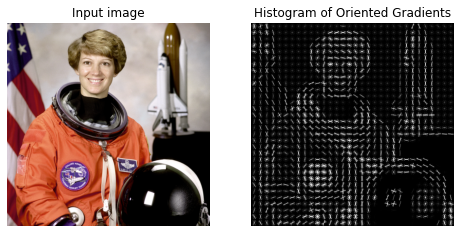

In [3]:
image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# HOG in Action: A Simple Face Detector

Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator. The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

reference: https://jakevdp.github.io/PythonDataScienceHandbook/05.14-image-features.html

### 1. Obtain a set of positive training samples

Let's start by finding some positive training samples that show a variety of faces. We have one easy set of data to work with—the 'Labeled Faces in the Wild dataset', which can be downloaded by Scikit-Learn:

In [4]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

### 2. Obtain a set of negative training samples

Next we need a set of similarly sized thumbnails which do not have a face in them. One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales. Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's PatchExtractor:

In [5]:
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [6]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

We now have 30,000 suitable image patches which do not contain faces. Let's take a look at a few of them to get an idea of what they look like:

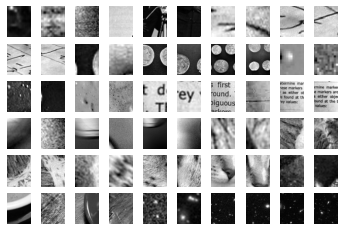

In [7]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

### 3. Combine sets and extract HOG features

Now that we have these positive samples and negative samples, we can combine them and compute HOG features. This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [8]:
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

X_train.shape

(43233, 1215)

### 4. Training a support vector machine

Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches. For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.94726495, 0.97131953, 0.97189777, 0.97478603, 0.97455471])

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9887354267133868

In [11]:
grid.best_params_

{'C': 1.0}

In [12]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC()

### 5. Find faces in a new image

Now that we have this model in place, let's grab a new image and see how the model does. We will use prepare images of ours, and run a sliding window over it and evaluate each patch:

For more images, see

https://scikit-image.org/docs/dev/api/skimage.data.html?highlight=data#module-skimage.data

C:\Users\Mas\Anaconda3\lib\site-packages\skimage\transform\_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


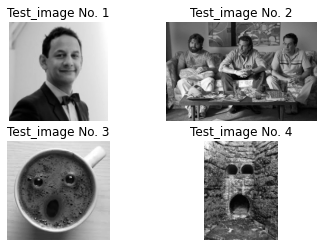

In [13]:
# Test images input for doing experiments

t1 = cv2.imread('images/1.jpg',0) 
t1 = color.rgb2gray(t1)
t1 = transform.rescale(t1, 0.5)


t2 = cv2.imread('images/2.jpg',0) 
t2 = color.rgb2gray(t2)
t2 = transform.rescale(t2, 0.5)

t3 = cv2.imread('images/3.jpg',0) 
t3 = color.rgb2gray(t3)
t3 = transform.rescale(t3, 0.5)

t4 = cv2.imread('images/4.jpg',0) 
t4 = color.rgb2gray(t4)
t4 = transform.rescale(t4, 0.5)



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.axis('off')
ax1.imshow(t1, cmap=plt.cm.gray)
ax1.set_title('Test_image No. 1')

ax2.axis('off')
ax2.imshow(t2, cmap=plt.cm.gray)
ax2.set_title('Test_image No. 2')

ax3.axis('off')
ax3.imshow(t3, cmap=plt.cm.gray)
ax3.set_title('Test_image No. 3')

ax4.axis('off')
ax4.imshow(t4, cmap=plt.cm.gray)
ax4.set_title('Test_image No. 4')

plt.show()

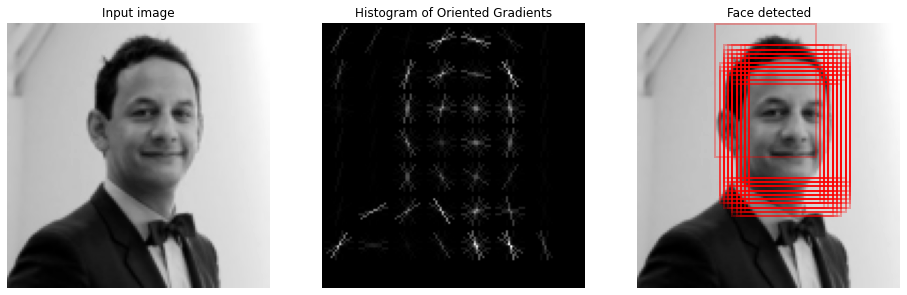

In [14]:
### Changing the input of test images here #### 
test_image = cv2.imread('images/1.jpg',0)   


test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)


def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

#Finally, we can take these HOG-featured patches and use our model 
#to evaluate whether each patch contains a face:

labels = model.predict(patches_hog)
labels.sum()

## HOG features for display
fd, hog_image = feature.hog(test_image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

ax3.axis('off')
ax3.imshow(test_image, cmap=plt.cm.gray)
ax3.set_title('Face detected')





Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax3.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))
    
    
    

plt.show()
    
    
    

#### Inline question 1:
ใ้ห้นิสิตทำการทดลอง เปรียบเทียบภาพอินพุตที่กำหนดให้ (ex, 1 - 4 images) เเล้วลองวิเคราะห์อธิบายตามความเข้าใจถึงข้อผิดพลาดในการตรวจจับในหน้าในแต่ละรูป  เพราะอะไร และหากอยากทำให้ผลลัพธ์มีความแม่นยำและถูกต้องมากขึ้น นิสิตมีความคิดเห็นอย่างไร
Describe the misclassification results that you see. Do they make sense?

In [15]:
### Answer here ###

